# Next level development of new infrastructure based on TDI filter
In the new structure, PCI and TDI filters share a common infrastructure.  We develop that infrastrucutre here using the TDI kernels, as TDI is well understood, and can be compared with a well-established result.

Key common elements for development and testing are the common infrastructure for estimating sensitivities and for interpolating results from time-local kernels for application across a wider temporal stretch of data.


In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy
from pcipy.data import TimeData
from pcipy.tdi_filter import DeducedTDIFilter as TDIFilter

## Read in data sets

In [2]:
if 0:
    datadir = "/data/jgbaker/software/pylisa/data/"
    orbits = datadir+"keplerian-orbits.h5"
    workdir = datadir+"/simulations/"
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
    gw_file_base = "2025-07-01_19h34_"
if 1:
    datadir = "/data/jgbaker/software/pcipy/data"
    workdir = datadir+"/simulations/"
    if 1:
        orbits = workdir+"keplerian-orbits.h5"
        noise_file_base = "2025-04-07_keplerian_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_keplerian_"
    else:
        orbits = workdir+"equalarm-orbits.h5"
        noise_file_base = "2025-04-07_equalarm_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_equalarm_"

skip=1000


#### Basic single-link noise data

In [3]:
noise_sim_path = workdir+noise_file_base+"measurements_4Hz.h5"

#get the central frequency
sim = h5py.File(noise_sim_path, 'r')
central_freq = sim.attrs['central_freq']
sim.close()

data_noise = Data.from_instrument(noise_sim_path)
fs = data_noise.fs

in_chans=["isi"]
in_chans=["isi","rfi","tmi"]
#in_chans=["isi","rfi","tmi","isi_sb","rfi_sb"]

#in_chans=["isi"]
in_chansGW=["isi"]

def make_names(in_chans):
    mosas_order = ['12', '23', '31', '13', '21', '32']
    names=[]
    for chan in in_chans:
        for link in mosas_order:
            names.append(f'{chan}_{link}')
    return names

#setup instrumental channels
y_names = make_names(in_chans)
#we have to divide by central_freq because the instument sumlation channels are in beat-rate units
y_list = [data_noise.measurements[name]/central_freq for name in y_names]
y_n = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=y_names)

You are using a measurement file in a version that might not be fully supported


#### Matching GW simulations results for the empirical sensitivity calculation

In [4]:
gw_path = workdir+gw_file_base+"gw_measurements_4Hz.h5"

data_gw = Data.from_gws(gw_path,orbits)

y_namesGW = make_names(in_chansGW)
#note: the GW mesaurement data are already fractional frequency so we don't divide by central_freq
y_list = [data_gw.measurements[name] for name in y_namesGW]
display(y_list)
np.array(y_list, dtype=np.float64)
y_gw = TimeData(np.array(y_list, dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names=y_namesGW)

You are using a GW file in a development version
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


[array([ 0.85221103,  0.64236179, -0.660586  , ..., -1.94593982,
         0.17747689, -1.66847782], shape=(1036800,)),
 array([-0.36785764,  0.01970518,  0.14511895, ..., -0.04970868,
        -0.09606979, -0.48545533], shape=(1036800,)),
 array([ 0.77215357, -1.36680461, -0.05450318, ..., -0.3160359 ,
        -0.77210703, -0.91221723], shape=(1036800,)),
 array([-2.14420271, -0.91742178,  0.76044897, ...,  0.28165959,
        -1.94137956, -1.92178592], shape=(1036800,)),
 array([-0.03011097,  0.01204994, -0.17068137, ...,  0.00808109,
         0.08929396,  0.2333917 ], shape=(1036800,)),
 array([ 0.08427693, -0.57987423,  1.91482474, ...,  0.00591381,
        -0.06678223,  1.68501076], shape=(1036800,))]

#### For comparison, we also need the TDI data

In [5]:
#TDI noise from file
tdipath2 = workdir +  noise_file_base + 'noise_tdi2_4Hz.h5'

tdi2 = h5py.File(tdipath2, 'r')
x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq
tdi2.close()

XYZ_file_noise = TimeData(np.array([x2_noise,y2_noise,z2_noise], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')

#GW
tdi2_gw_file = workdir+gw_file_base+"gw_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()] #/ central_freq  (gw simulation already in fractional freq)
y2_gw = hdf5['y'][()] #/ central_freq
z2_gw = hdf5['z'][()] #/ central_freq
hdf5.close()

XYZ_file_gw = TimeData(np.array([x2_gw,y2_gw,z2_gw], dtype=np.float64)[:,skip:],dt=1/fs,t0=skip/fs,names='XYZ')


#### Define data range for this study and set up fourier transforms

In [6]:
range_in_hours = 8
ibuff=250   #edge buffer for kernels 

ns = int(range_in_hours * 3600 * fs) # less for dev

In [7]:
#Construct data sets
ytest_n = y_n.get_range(0,ns+2*ibuff)
ytest_gw = y_gw.get_range(0,ns+2*ibuff)

TDItest_n = XYZ_file_noise.get_range(0,ns+2*ibuff)
TDItest_gw = XYZ_file_gw.get_range(0,ns+2*ibuff)


(18, 1035800)
(6, 1035800)
(3, 1035800)
(3, 1035800)


In [8]:
#Fourier Transform
import pyfftw
from pyfftw.interfaces.numpy_fft import rfft, irfft, fft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain

wd = np.blackman(ns)

## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)

def do_ft(dataset, fs=fs):
    ns=dataset.n_samples()
    wd=np.blackman(ns)
    f = np.fft.rfftfreq(ns) * fs
    sel=f>0
    #print(sel)
    dataset_fft=[rfft(wd * dataset.data[i] ) * np.sqrt(2/(fs*k2)) for i in range(dataset.n_channels())]
    
    return f[sel], np.array(dataset_fft)[:,sel]

In [9]:
ytest_n.data.shape

(18, 115700)

In [10]:
'''
def linear_interp_data(channel_sets,kernel_times):
    #This function produces an output channel set from two input time-domain channel sets by linear interpolation
    #Each of the two input channels is treated as corresponding to a specific kernel_time and the
    #output should match that channel at that time.  At other times, the output is a linar interpolant
    #The output times are the same as channel set times
    times = get_times(channel_sets[0])
    eps = (times-kernel_times[0])/(kernel_times[1]-kernel_times[0])
    return TimeData(channel_sets[0].data*(1-eps) + channel_sets[1].data*eps, channel_sets[0].dt, channel_sets[0].t0, channel_sets[0].names)
'''

def piecewise_linear_apply_filter_set(input_data, filter_set, kernel_times, **filter_kwargs):
    '''
    This function produces an output channel set, based on the input_data, from a set of input time-domain filters by 
    piecewise linear interpolation.

    The filters are expected to be optimized at the corresponding kernel times, and time-ordered.
    Then, working across the time domain, the nearest filters are selected pairwise and linear interpolation
    provides the result for the corresponding times. 
    '''

    # 1. First some consistency checks. All of these might be obviated if controlled separately
    # Times should be ordered
    assert np.all(kernel_times[:-1] < kernel_times[1:]), "Values in kernel_times must be ordered and increasing"
    # Output channels should match
    for i in range(len(filter_set)-1):
        assert filter_set[i].n_output_channels==filter_set[i+1].n_output_channels and np.all(filter_set[i].output_names==filter_set[i+1].output_names),'Output channels do not make for filters '+str(i)+' and '+str(i+1)
    # For simplicity we demand that the kernel stencils be the same for each filter. This isn't strictly necessary
    # for the interpolation to make sense, but it does simplify the calculation a little.  Could be relaxed later.
    nleft=[filt.nleft for filt in filter_set]
    nright=[filt.nright for filt in filter_set]
    assert np.all(nleft[:-1]==nleft[1:]) and np.all(nright[:-1]==nright[1:]), "Not all filter stencils match."
    nleft=nleft[0]
    nright=nright[0]
    #Require commensurate dt
    dt=[filt.dt for filt in filter_set]
    assert np.all((dt[:-1]==dt[1:])),"Not all filter cadences agree."
    dt=dt[0]
    
    # 2. Identify the extent of the 'valid' part of the output time domain.
    output_t0=input_data.t0+nleft*dt
    output_n=input_data.n_samples()-nleft-nright
    output_times=output_t0+np.arange(output_n)*dt
    output_data=np.zeros((filter_set[0].n_output_channels,output_n))
    
    # 3. Next we need to split the output time domain into a set of subdomains with an assigned pair of nearest filters
    # The subdomains are bounded by the points of nearest kernel times
    kernel_time_indices=np.array([int(x) for x in ((kernel_times-output_t0)/dt+0.5)])
    
    print('kti',kernel_times,kernel_time_indices)
    select_bounds=np.arange(1,len(kernel_times)-1,dtype=int) #No bound associated with outermost filters since we need filter pairs
    #enforce that internal bounds should be strictly internal
    print('sel bounds',select_bounds)
    if len(select_bounds>0): 
        print('ktis',kernel_time_indices[select_bounds])
        select_bounds=select_bounds[kernel_time_indices[select_bounds]>0]
    print('sel bounds',select_bounds)
    if len(select_bounds>0): select_bounds=select_bounds[kernel_time_indices[select_bounds]<output_n-1]
    print('sel bounds',select_bounds)
    istarts=np.concatenate(([0],[kernel_time_indices[i] for i in select_bounds])).astype(int)
    iends=np.concatenate(([kernel_time_indices[i] for i in select_bounds],[output_n])).astype(int)
    k0=0
    if len(select_bounds)>0 and select_bounds[0]>0: k0=select_bounds[0]-1
    left_kernel_inds=np.concatenate(([k0],select_bounds))
    if k0>=len(kernel_times)-1: right_kernel_inds=left_kernel_inds
    else:
        right_kernel_inds=left_kernel_inds+1
    nsegs=len(istarts)
    print('n,starts,ends,kleft,kright',nsegs, istarts, iends, left_kernel_inds, right_kernel_inds)

    # 4. Now do apply the filter pairs and linearly interpolate to get the output for each subdomain segment
    #We begin by initiating the left filter version of data
    in_data=input_data.get_range(istarts[0],iends[0]+nleft+nright)
    filt=filter_set[left_kernel_inds[0]]
    left_data=filt.apply_filter(in_data,**filter_kwargs)
    left_istart=istarts[0]
    for j in range(nsegs):
        istart=istarts[j]
        iend=iends[j]
        kleft=left_kernel_inds[j]
        kright=right_kernel_inds[j]
        # A. Compute the right filter version of data 
        jnext=j+1
        if jnext>=nsegs: jnext=nsegs-1
        #we apply the right filter so that it can also be the left filter of next step (if it exists)
        iend_next=iends[jnext] 
        # Note that input data is staggered by nleft from output data
        # and that we also need a buffer by nleft on the left and nright on the right to get data for our output range
        in_data=input_data.get_range(istart,iend_next+nleft+nright)
        filt=filter_set[kright]
        right_data=filt.apply_filter(in_data,**filter_kwargs)
        
        # B. perform linear interpolation on this subdomian
        seg_times = output_times[istart:iend]
        eps = (seg_times-kernel_times[kleft])/(kernel_times[kright]-kernel_times[kleft]+1e-100)
        print(eps)
        print('left',left_data.n_samples(),istart-left_istart,iend-left_istart)
        left_seg_data = left_data.data[:,istart-left_istart:iend-left_istart]
        print('right',right_data.n_samples(),0,iend-istart)
        right_seg_data = right_data.data[:,:iend-istart] 
        print('shapes',left_seg_data.shape,right_seg_data.shape)
        seg_data = left_seg_data + (right_seg_data-left_seg_data)*eps
        output_data[:,istart:iend]=seg_data

        # C. Swap right to left
        left_data=right_data
        left_istart=istart
        
    return TimeData(output_data, dt, output_t0, filter_set[0].output_names)

def select_kernel_times(td,nkern):
    #define kernel times

    #first define on unit interval
    ktimes = ( 0.5 + np.arange(nkern) ) / ( nkern )
    #print(ktimes)
    #then scale for td
    ktimes = td.t0 + (td.dt * td.n_samples()) * ktimes
    #print(ktimes)
    return ktimes
    


In [11]:
from pcipy.tdi_filter import LinearFilter

class PiecewiseFilter(LinearFilter):

    def __init__(self, tstart, tend, nkern, subfilter_class, **subfilter_kwargs):
        self.construct_sub_filters(subfilter_class, subfilter_kwargs, tstart, tend, nkern)
                 
    def apply_filter(self, input_data, check=True, method='convolve'):
        '''
        Apply the encoded filter to the input_data.

        In this implementation the filter produces an output channel set, based on the input_data, from the previously 
        generated set of input time-domain filters by piecewise linear interpolation.

        Parameters
        ----------
        input_data : TimeData
            The data to be filtered.
        check : bool, optional
            Whether to check the data before applying the filter (def True).
        method : str
            Variants on how to realize the computation, 'dot' for a direct
            approach using np.dot, or 'convolve' using scipy.signal.convolve 
        '''

        return PiecewiseFilter.piecewise_linear_apply_filter_set(input_data, self.subfilters, self.kernel_times, check=check, method=method)
        
    def construct_sub_filters(self, subfilter_class, subfilter_kwargs, tstart, tend, nkern):
        '''
        This function assumes that subfilter constructor has an argument "eval_time" which is the only argument which differs as the
        in the construction of the subfilter instances.  This function may be used by a child class, or replaced with something more
        sophisticated.

        Args:
          tstart           double     Start time for filter application range
          tend             double     End time for filter application range
          nkern            int        Number of kernels pieces to use in piece-wise linear combination
          subfilter_class  class      Class for the subfilters
          subfilter_kwargs dict       Additional arguments for the sub_filter constructor
        '''
        #1. First determine the time grid for kernel definition
    
        #first define on unit interval
        ktimes = ( 0.5 + np.arange(nkern) ) / ( nkern )
        #print(ktimes)
        #then scale for the target time-stretch
        ktimes = tstart + (tend - tstart) * ktimes
        self.kernel_times=ktimes

        #2. Next construct the filters. For this example, we use raw LinearFilter objects, but a practical implementation will use a derived class        
        self.subfilters = [ subfilter_class(eval_time=t,**subfilter_kwargs) for t in self.kernel_times]
    
        
    # Internally ulitized functions
    
    def select_kernel_times(td,nkern):
        #define kernel times
    
        #first define on unit interval
        ktimes = ( 0.5 + np.arange(nkern) ) / ( nkern )
        #print(ktimes)
        #then scale for td
        ktimes = td.t0 + td.dt * td.n_samples() * ktimes
        #print(ktimes)
        return ktimes

    def piecewise_linear_apply_filter_set(input_data, filter_set, kernel_times, **filter_kwargs):
        '''
        This function produces an output channel set, based on the input_data, from a set of input time-domain filters by 
        piecewise linear interpolation.
    
        The filters are expected to be optimized at the corresponding kernel times, and time-ordered.
        Then, working across the time domain, the nearest filters are selected pairwise and linear interpolation
        provides the result for the corresponding times. 
        '''
    
        # 1. First some consistency checks. All of these might be obviated if controlled separately
        # Times should be ordered
        assert np.all(kernel_times[:-1] < kernel_times[1:]), "Values in kernel_times must be ordered and increasing"
        # Output channels should match
        for i in range(len(filter_set)-1):
            assert filter_set[i].n_output_channels==filter_set[i+1].n_output_channels and np.all(filter_set[i].output_names==filter_set[i+1].output_names),'Output channels do not make for filters '+str(i)+' and '+str(i+1)
        # For simplicity we demand that the kernel stencils be the same for each filter. This isn't strictly necessary
        # for the interpolation to make sense, but it does simplify the calculation a little.  Could be relaxed later.
        nleft=[filt.nleft for filt in filter_set]
        nright=[filt.nright for filt in filter_set]
        assert np.all(nleft[:-1]==nleft[1:]) and np.all(nright[:-1]==nright[1:]), "Not all filter stencils match."
        nleft=nleft[0]
        nright=nright[0]
        print('nleft, nright',nleft,nright)
        #Require commensurate dt
        dt=[filt.dt for filt in filter_set]
        assert np.all((dt[:-1]==dt[1:])),"Not all filter cadences agree."
        dt=dt[0]
        
        # 2. Identify the extent of the 'valid' part of the output time domain.
        output_t0=input_data.t0+nleft*dt
        output_n=input_data.n_samples()-nleft-nright
        output_times=output_t0+np.arange(output_n)*dt
        output_data=np.zeros((filter_set[0].n_output_channels,output_n))
        
        # 3. Next we need to split the output time domain into a set of subdomains with an assigned pair of nearest filters
        # The subdomains are bounded by the points of nearest kernel times
        kernel_time_indices=np.array([int(x) for x in ((kernel_times-output_t0)/dt+0.5)])
        
        print('kti',kernel_times,kernel_time_indices)
        select_bounds=np.arange(1,len(kernel_times)-1,dtype=int) #No bound associated with outermost filters since we need filter pairs
        #enforce that internal bounds should be strictly internal
        print('sel bounds',select_bounds)
        if len(select_bounds>0): 
            print('ktis',kernel_time_indices[select_bounds])
            select_bounds=select_bounds[kernel_time_indices[select_bounds]>0]
        print('sel bounds',select_bounds)
        if len(select_bounds>0): select_bounds=select_bounds[kernel_time_indices[select_bounds]<output_n-1]
        print('sel bounds',select_bounds)
        istarts=np.concatenate(([0],[kernel_time_indices[i] for i in select_bounds])).astype(int)
        iends=np.concatenate(([kernel_time_indices[i] for i in select_bounds],[output_n])).astype(int)
        k0=0
        if len(select_bounds)>0 and select_bounds[0]>0: k0=select_bounds[0]-1
        left_kernel_inds=np.concatenate(([k0],select_bounds))
        if k0>=len(kernel_times)-1: right_kernel_inds=left_kernel_inds
        else:
            right_kernel_inds=left_kernel_inds+1
        nsegs=len(istarts)
        print('n,starts,ends,kleft,kright',nsegs, istarts, iends, left_kernel_inds, right_kernel_inds)
    
        # 4. Now do apply the filter pairs and linearly interpolate to get the output for each subdomain segment
        #We begin by initiating the left filter version of data
        in_data=input_data.get_range(istarts[0],iends[0]+nleft+nright)
        filt=filter_set[left_kernel_inds[0]]
        left_data=filt.apply_filter(in_data,**filter_kwargs)
        left_istart=istarts[0]
        for j in range(nsegs):
            print('filtering segment',j)
            istart=istarts[j]
            iend=iends[j]
            kleft=left_kernel_inds[j]
            kright=right_kernel_inds[j]
            # A. Compute the right filter version of data 
            jnext=j+1
            if jnext>=nsegs: jnext=nsegs-1
            #we apply the right filter so that it can also be the left filter of next step (if it exists)
            iend_next=iends[jnext] 
            # Note that input data is staggered by nleft from output data
            # and that we also need a buffer by nleft on the left and nright on the right to get data for our output range
            in_data=input_data.get_range(istart,iend_next+nleft+nright)
            filt=filter_set[kright]
            right_data=filt.apply_filter(in_data,**filter_kwargs)
            
            # B. perform linear interpolation on this subdomian
            seg_times = output_times[istart:iend]
            eps = (seg_times-kernel_times[kleft])/(kernel_times[kright]-kernel_times[kleft]+1e-100)
            print(eps)
            print('left',left_data.n_samples(),istart-left_istart,iend-left_istart)
            left_seg_data = left_data.data[:,istart-left_istart:iend-left_istart]
            print('right',right_data.n_samples(),0,iend-istart)
            right_seg_data = right_data.data[:,:iend-istart] 
            print('shapes',left_seg_data.shape,right_seg_data.shape)
            seg_data = left_seg_data + (right_seg_data-left_seg_data)*eps
            output_data[:,istart:iend]=seg_data
    
            # C. Swap right to left
            left_data=right_data
            left_istart=istart
            
        return TimeData(output_data, dt, output_t0, filter_set[0].output_names)

from pcipy.filter import PiecewiseFilter as PiecewiseFilter_module

# The following line overrides the definition above for the corresponding one in the module
PiecewiseFilter = PiecewiseFilter_module


### Piecewise linear interpolation

In [12]:
#class version: __init__(self, tstart, tend, nkern, subfilter_class, **subfilter_kwargs)
tbuff=0
tstart=ytest_n.t0 - tbuff
tend=ytest_n.t0+ytest_n.dt*ytest_n.n_samples()  + tbuff

pwFilter=PiecewiseFilter(tstart,tend,4,TDIFilter, measurements_data=data_noise,in_chans=in_chans,method='linear')

pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0


In [13]:
XYZpw=pwFilter.apply_filter(ytest_n,check=True)
print(ytest_n.n_samples(),XYZpw.n_samples())
print(ytest_n.dt,XYZpw.dt)
print(ytest_n.t0,XYZpw.t0)

kti [ 3865.625 11096.875 18328.125 25559.375] [ 14181  43106  72031 100956]
sel bounds [1 2]
ktis [43106 72031]
sel bounds [1 2]
sel bounds [1 2]
n,starts,ends,kleft,kright 3 [    0 43106 72031] [ 43106  72031 115418] [0 1 2] [1 2 3]
(18, 115700)
(18, 115700)
[-0.49025065 -0.49021608 -0.4901815  ...  0.99991357  0.99994814
  0.99998271]
left 43106 0 43106
right 72031 0 43106
shapes (3, 43106) (3, 43106)
(18, 115700)
[1.72860847e-05 5.18582541e-05 8.64304235e-05 ... 9.99913570e-01
 9.99948142e-01 9.99982714e-01]
left 72031 43106 72031
right 72312 0 28925
shapes (3, 28925) (3, 28925)
(18, 115700)
[1.72860847e-05 5.18582541e-05 8.64304235e-05 ... 1.49989628e+00
 1.49993086e+00 1.49996543e+00]
left 72312 28925 72312
right 43387 0 43387
shapes (3, 43387) (3, 43387)
115700 115418
0.25 0.25
250.0 320.5


In [14]:
#Construct filters
nks = [8,4,2,1]
tks = [select_kernel_times(ytest_n,nk) for nk in nks]
filtsets = [ [ TDIFilter(data_noise,eval_time=t,in_chans=in_chans,method='linear') for t in select_kernel_times(ytest_n,nk) ] for nk in nks]

display(tks)


pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0
pastwidth: 283
tdi_filter: nleft, nright: 282 0


[array([ 2057.8125,  5673.4375,  9289.0625, 12904.6875, 16520.3125,
        20135.9375, 23751.5625, 27367.1875]),
 array([ 3865.625, 11096.875, 18328.125, 25559.375]),
 array([ 7481.25, 21943.75]),
 array([14712.5])]

In [15]:
#Apply filters for linear interpolation
XYZset_n = [ piecewise_linear_apply_filter_set(ytest_n, filtsets[i], tks[i]) for i in range(len(nks))]
for s in XYZset_n: print(s.n_samples())
    

kti [ 2057.8125  5673.4375  9289.0625 12904.6875 16520.3125 20135.9375
 23751.5625 27367.1875] [  6949  21412  35874  50337  64799  79262  93724 108187]
sel bounds [1 2 3 4 5 6]
ktis [21412 35874 50337 64799 79262 93724]
sel bounds [1 2 3 4 5 6]
sel bounds [1 2 3 4 5 6]
n,starts,ends,kleft,kright 7 [    0 21412 35874 50337 64799 79262 93724] [ 21412  35874  50337  64799  79262  93724 115418] [0 1 2 3 4 5 6] [1 2 3 4 5 6 7]
(18, 115700)
(18, 115700)
[-0.4805013  -0.48043215 -0.48036301 ...  0.99980985  0.999879
  0.99994814]
left 21412 0 21412
right 35874 0 21412
shapes (3, 21412) (3, 21412)
(18, 115700)
[1.72860847e-05 8.64304235e-05 1.55574762e-04 ... 9.99775281e-01
 9.99844425e-01 9.99913570e-01]
left 35874 21412 35874
right 28925 0 14462
shapes (3, 14462) (3, 14462)
(18, 115700)
[-1.72860847e-05  5.18582541e-05  1.21002593e-04 ...  9.99809853e-01
  9.99878997e-01  9.99948142e-01]
left 28925 14462 28925
right 28925 0 14463
shapes (3, 14463) (3, 14463)
(18, 115700)
[1.72860847e-05 8.6

min -6.738158113018015e-20
max 6.830005318877845e-20
mean 1.5752627525550274e-25
std 6.177592491559503e-21
refshape: (11042,)
time offest check: 0.0
data shape: (11042,)
time offest check: 0.0
data shape: (11042,)
time offest check: 0.0
data shape: (11042,)
time offest check: 0.0
data shape: (11042,)
time offest check: 0.0
data shape: (11042,)
              total        used        free      shared  buff/cache   available
Mem:       15911324     3367848    10177780        1276     2365696    12233324
Swap:             0           0           0


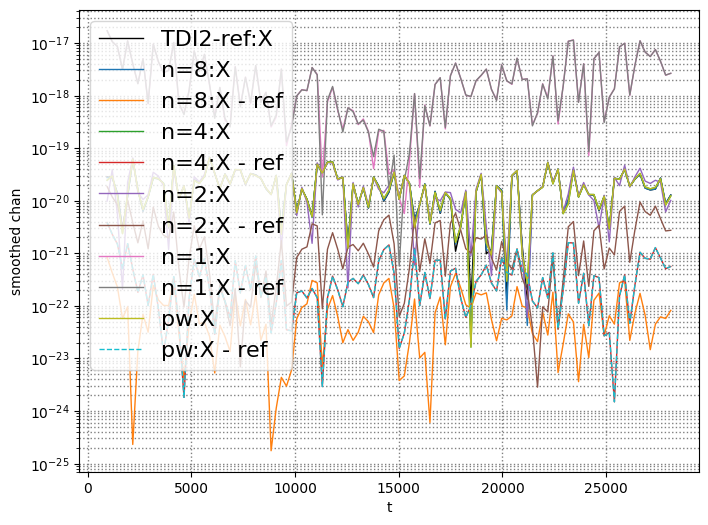

In [16]:
import scipy
# View data in decimated in the time domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

idec = 10
iev=100
ibegin=0
iend=1000000

ixyz=0
#iskip=249
iskip=282

ioff=len(TDItest_n.data[ixyz])

delta=XYZset_n[0].data[ixyz]-TDItest_n.data[ixyz][iskip:]
print('min',np.min(delta))
print('max',np.max(delta))
print('mean',np.mean(delta))
print('std',np.std(delta))

do_dec=lambda x:scipy.signal.decimate(x,q=idec)[ibuff:-ibuff]
#epsd=do_dec(eps[:])


data=do_dec(TDItest_n.data[ixyz][iskip:])
times=do_dec(TDItest_n.get_times()[iskip:])    
refdata=data
reftimes=times
print('refshape:',refdata.shape)

axes.semilogy(times[ibegin:iend:iev], np.abs(data[ibegin:iend:iev]), c='k', linewidth=1, label='TDI2-ref:'+'XYZ'[ixyz])

for iset in range(len(XYZset_n)):
    data=do_dec(XYZset_n[iset].data[ixyz])
    times=do_dec(XYZset_n[iset].get_times())
    print('time offest check:', np.mean(times-reftimes))
    print('data shape:',data.shape)
    axes.semilogy(times[ibegin:iend:iev], np.abs(data[ibegin:iend:iev]), linewidth=1, label='n='+str(nks[iset])+':'+'XYZ'[ixyz])
    axes.semilogy(times[ibegin:iend:iev], 1e-25+np.abs((data-refdata)[ibegin:iend:iev]), linewidth=1, label='n='+str(nks[iset])+':'+'XYZ'[ixyz]+' - ref')
    #refdata=data

if 1:
    data=do_dec(XYZpw.data[ixyz])
    times=do_dec(XYZpw.get_times())
    print('time offest check:', np.mean(times-reftimes))
    print('data shape:',data.shape)
    axes.semilogy(times[ibegin:iend:iev], np.abs(data[ibegin:iend:iev]), linewidth=1, label='pw:'+'XYZ'[ixyz])
    axes.semilogy(times[ibegin:iend:iev], 1e-25+np.abs((data-refdata)[ibegin:iend:iev]), linewidth=1, ls='--', label='pw:'+'XYZ'[ixyz]+' - ref')
    
axes.set_xlabel(r"t")
axes.set_ylabel(r"smoothed chan")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
#axes.set_xlim([1e-4, 0.1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

(3, 115700)


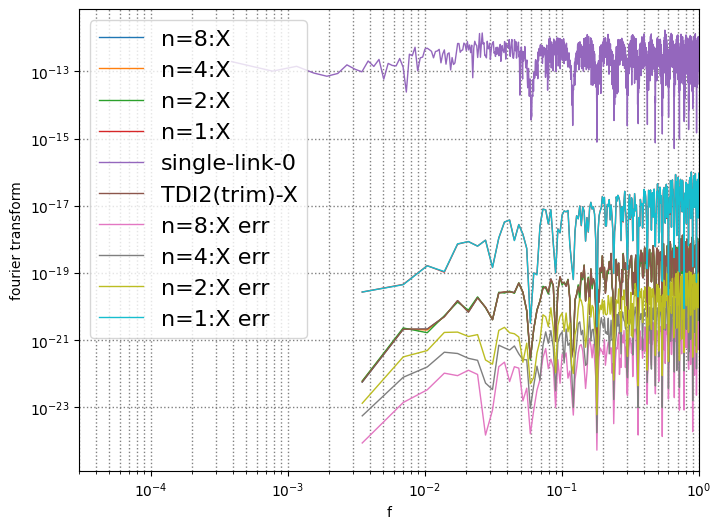

In [17]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 100
i0=iev

ixyz=0

#f,data=do_ft(XYZ_file_nois
#axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, label='TDI2-'+'XYZ'[ixyz])

for iset in range(len(XYZset_n)):
    f,data=do_ft(XYZset_n[iset])
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='n='+str(nks[iset])+':'+'XYZ'[ixyz])
               
for iy in range(1):
    f,data=do_ft(y_n)
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[iy,i0::iev]), linewidth=1, label="single-link-"+str(iy))


f,data=do_ft(TDItest_n.get_range(iskip,None))
dataref=data
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, label='TDI2(trim)-'+'XYZ'[ixyz])

for iset in range(len(XYZset_n)):
    f,data=do_ft(XYZset_n[iset])
    data=data-dataref
    axes.loglog(f[i0::iev], (1+iset*0)*np.abs(data[ixyz,i0::iev]), linewidth=1, label='n='+str(nks[iset])+':'+'XYZ'[ixyz]+' err')
               


axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([.3e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()